In [11]:
# Import all packages required

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For building the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense

# For evaluating the model
from sklearn.metrics import mean_squared_error

In [12]:
# Import data
df = pd.read_csv('traindataset.csv')

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9357 non-null   int64  
 1   CO      9357 non-null   float64
 2   C6H6    9357 non-null   float64
 3   T       9357 non-null   float64
 4   RH      9357 non-null   float64
 5   NOx     9357 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 438.7 KB


In [15]:



# Rename columns to make it easier to understand
df = df.rename(columns={'CO': 'pollution',
                       'C6H6': 'Benzene',
                       'T': 'temperature',
                       'RH': 'humidity',
                       'NOx': 'NitricOxide'})

# The first 24 records have null pollution values
df = df[24:]

# Fill the other NA values in the pollution column to 0
# This is required during scaling
df = df.fillna(0)

df.head()

,Time,pollution,Benzene,temperature,humidity,NitricOxide
48,0,3.9,19.3,15.1,39.6,206
49,1,3.7,18.2,14.4,43.4,202
50,2,6.6,32.6,12.9,50.5,340
51,3,4.4,20.1,12.1,53.3,274
52,4,3.5,14.3,11.0,59.1,253


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

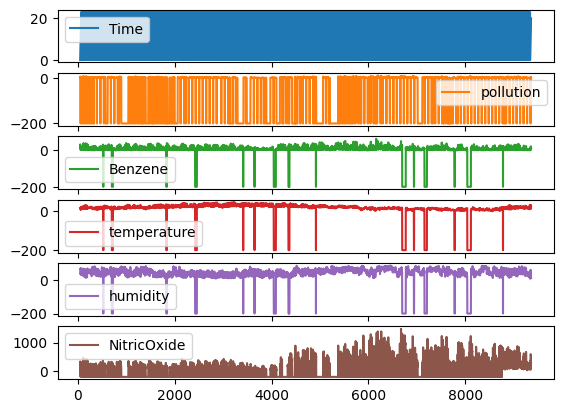

In [16]:
# A simple plot to visualize the correlation between the columns
df.plot(subplots=True)

In [17]:
# Scale the values in the dataframe to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df)

In [18]:
# Construct a DataFrame from the scaled 2d array
data = pd.DataFrame(values)

data.columns = df.columns
data.index = df.index

data.head()

,Time,pollution,Benzene,temperature,humidity,NitricOxide
48,0.000000,0.962246,0.831627,0.879395,0.829927,0.241811
49,0.043478,0.961303,0.827455,0.876533,0.843090,0.239428
50,0.086957,0.974988,0.882063,0.870401,0.867683,0.321620
51,0.130435,0.964606,0.834661,0.867130,0.877381,0.282311
52,0.173913,0.960359,0.812666,0.862633,0.897471,0.269803


In [19]:
#Shift the pollution column up to create the output variable
data['predicted_pollution'] = data['pollution'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
data = data.drop(data.tail(1).index)

data.head()

,Time,pollution,Benzene,temperature,humidity,NitricOxide,predicted_pollution
48,0.000000,0.962246,0.831627,0.879395,0.829927,0.241811,0.961303
49,0.043478,0.961303,0.827455,0.876533,0.843090,0.239428,0.974988
50,0.086957,0.974988,0.882063,0.870401,0.867683,0.321620,0.964606
51,0.130435,0.964606,0.834661,0.867130,0.877381,0.282311,0.960359
52,0.173913,0.960359,0.812666,0.862633,0.897471,0.269803,0.969325


In [20]:
# Split the dataset into training and testing datasets
# The first yesr is used as training data
train = data.values[:365 * 24]
test = data.values[365 * 24:]

# Separate input and output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Print all shapes
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 6), (8760,), (548, 1, 6), (548,))

In [22]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - loss: 0.3356 - val_loss: 0.0499 - 4s/epoch - 29ms/step
Epoch 2/50
122/122 - 0s - loss: 0.1561 - val_loss: 0.0434 - 332ms/epoch - 3ms/step
Epoch 3/50
122/122 - 0s - loss: 0.1296 - val_loss: 0.0412 - 337ms/epoch - 3ms/step
Epoch 4/50
122/122 - 0s - loss: 0.0967 - val_loss: 0.0440 - 342ms/epoch - 3ms/step
Epoch 5/50
122/122 - 0s - loss: 0.0535 - val_loss: 0.0347 - 327ms/epoch - 3ms/step
Epoch 6/50
122/122 - 0s - loss: 0.0439 - val_loss: 0.0343 - 330ms/epoch - 3ms/step
Epoch 7/50
122/122 - 0s - loss: 0.0429 - val_loss: 0.0348 - 346ms/epoch - 3ms/step
Epoch 8/50
122/122 - 0s - loss: 0.0425 - val_loss: 0.0341 - 330ms/epoch - 3ms/step
Epoch 9/50
122/122 - 0s - loss: 0.0421 - val_loss: 0.0347 - 343ms/epoch - 3ms/step
Epoch 10/50
122/122 - 0s - loss: 0.0423 - val_loss: 0.0340 - 360ms/epoch - 3ms/step
Epoch 11/50
122/122 - 0s - loss: 0.0419 - val_loss: 0.0338 - 492ms/epoch - 4ms/step
Epoch 12/50
122/122 - 0s - loss: 0.0416 - val_loss: 0.0353 - 470ms/epoch - 4ms/step
Epo

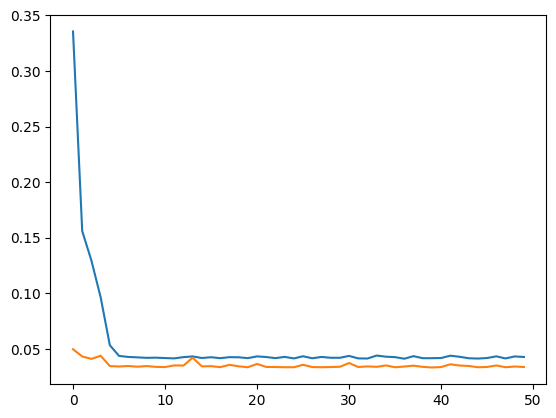

In [23]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

In [24]:
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

18/18 [==============================] - 1s 3ms/step


'3.951'